#Problem Synopsis:

In this notebook, we are trying to predict the click-through rate (the probability of someone selecting the ad). For search-engine advertisement using different variables related to the ad.
<br>
<br>
<br>



# Module Imports

In [ ]:
!pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance

# Dataset Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The overall dataset has already been split into 70% train and 30% test datasets.

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Code Portfolio/Predicting Click Through Rate/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Code Portfolio/Predicting Click Through Rate/test.csv")

In [ ]:
train_df.head()

,CTR,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,gender,age
0,0.0000,10,17,3,2,0.0136,0.0146,0.0000,0.0000,male,41+
1,0.0761,13,30,2,1,0.0373,0.0465,0.0382,0.0581,male,13-18
2,0.0426,12,14,1,1,0.0254,0.0310,0.0255,0.0323,male,13-18
3,0.0000,5,19,3,2,0.0178,0.0076,0.0035,0.0017,female,25-30
4,0.0068,11,17,2,2,0.0096,0.0069,0.0294,0.0171,female,19-24


# Exploratory Data Analysis (EDA)

## Initial Data Inspection and Summary Statistics

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CTR            4240 non-null   float64
 1   titleWords     4240 non-null   int64  
 2   adWords        4240 non-null   int64  
 3   depth          4240 non-null   int64  
 4   position       4240 non-null   int64  
 5   advCTR         4240 non-null   float64
 6   advCTRInPos    4240 non-null   float64
 7   queryCTR       4240 non-null   float64
 8   queryCTRInPos  4240 non-null   float64
 9   gender         4240 non-null   object 
 10  age            4240 non-null   object 
dtypes: float64(5), int64(4), object(2)
memory usage: 364.5+ KB


In [ ]:
train_df.describe()

,CTR,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos
count,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000
mean,0.054228,8.498113,21.442925,1.736792,1.291274,0.043681,0.046179,0.036981,0.040118
std,0.076921,2.950883,4.712799,0.675850,0.519331,0.039446,0.042515,0.039764,0.045251
min,0.000000,1.000000,2.000000,1.000000,1.000000,0.001700,0.000000,0.000000,0.000000
25%,0.009000,6.000000,19.000000,1.000000,1.000000,0.025100,0.022600,0.012975,0.011700
50%,0.028600,8.000000,22.000000,2.000000,1.000000,0.034300,0.035600,0.025600,0.027400
75%,0.066700,10.000000,25.000000,2.000000,2.000000,0.046725,0.049100,0.047000,0.052100
max,0.634300,21.000000,41.000000,3.000000,3.000000,0.519900,0.522600,0.579900,0.520500


In [ ]:
train_df.shape

(4240, 11)

In [ ]:
train_df.nunique()

,0
CTR,1260
titleWords,20
adWords,35
depth,3
position,3
advCTR,870
advCTRInPos,981
queryCTR,1078
queryCTRInPos,1156
gender,3


## 2. Univariate Analysis (Individual Variable Analysis)

In [ ]:
# Identify Numerical Columns
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols

Index(['CTR', 'titleWords', 'adWords', 'depth', 'position', 'advCTR',
       'advCTRInPos', 'queryCTR', 'queryCTRInPos'],
      dtype='object')

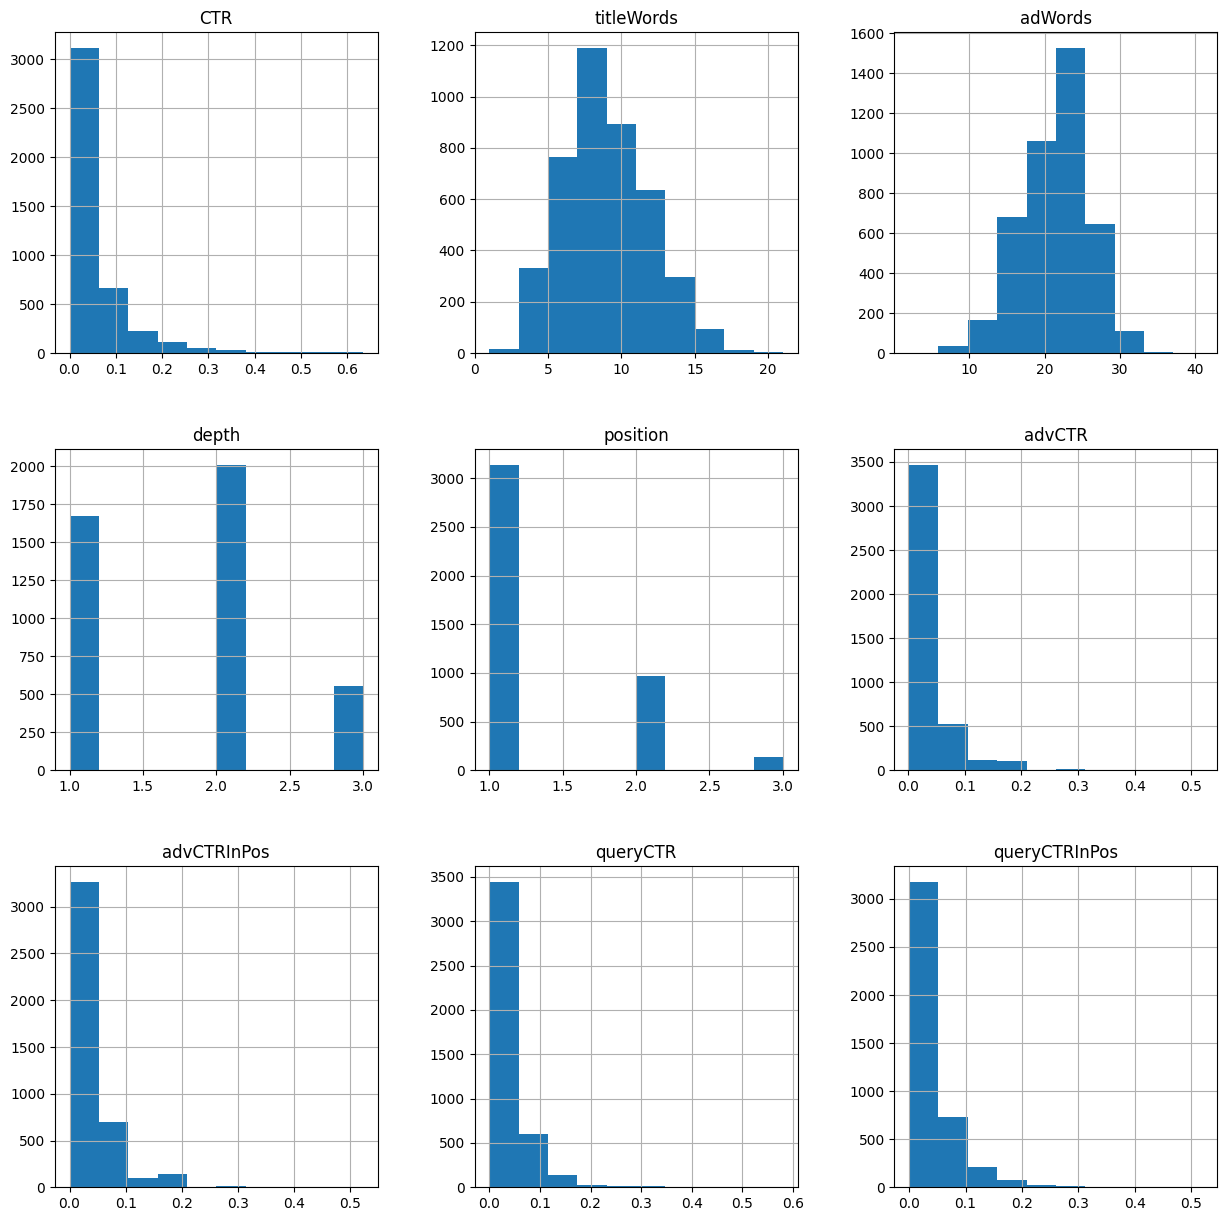

In [ ]:
# Creating Histograms for the numerical variables in the dataset to identify skewness, multi-modality, and potential outliers
train_df.hist(figsize=(15,15))
plt.show()

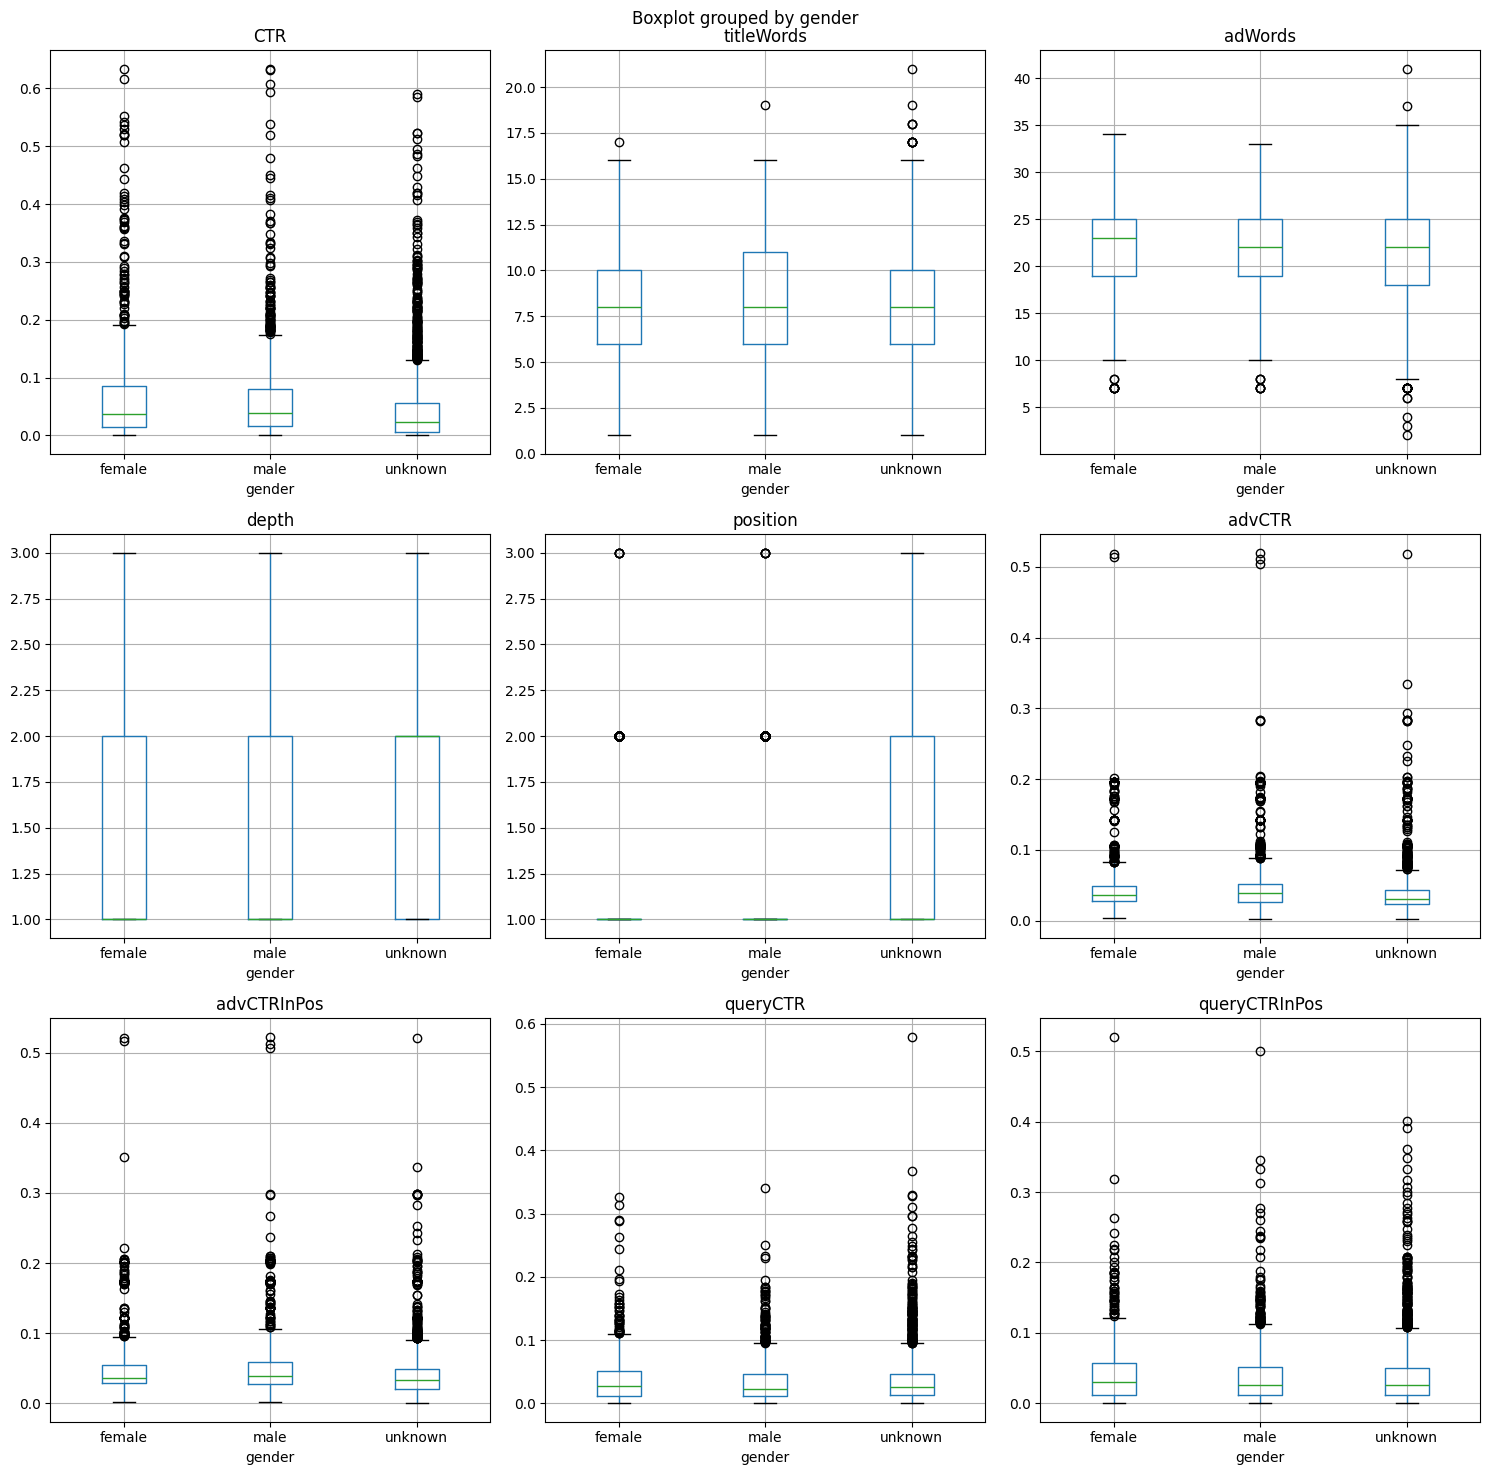

In [ ]:
# Analyzing the distribtion of the numerical values based on gender

# Create a figure and subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Iterate over numerical columns and plot boxplots for each gender
for i, col in enumerate(train_df[numerical_cols].columns):
    row = i // 3
    column = i % 3
    train_df.boxplot(column=col, by='gender', ax=axes[row, column])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

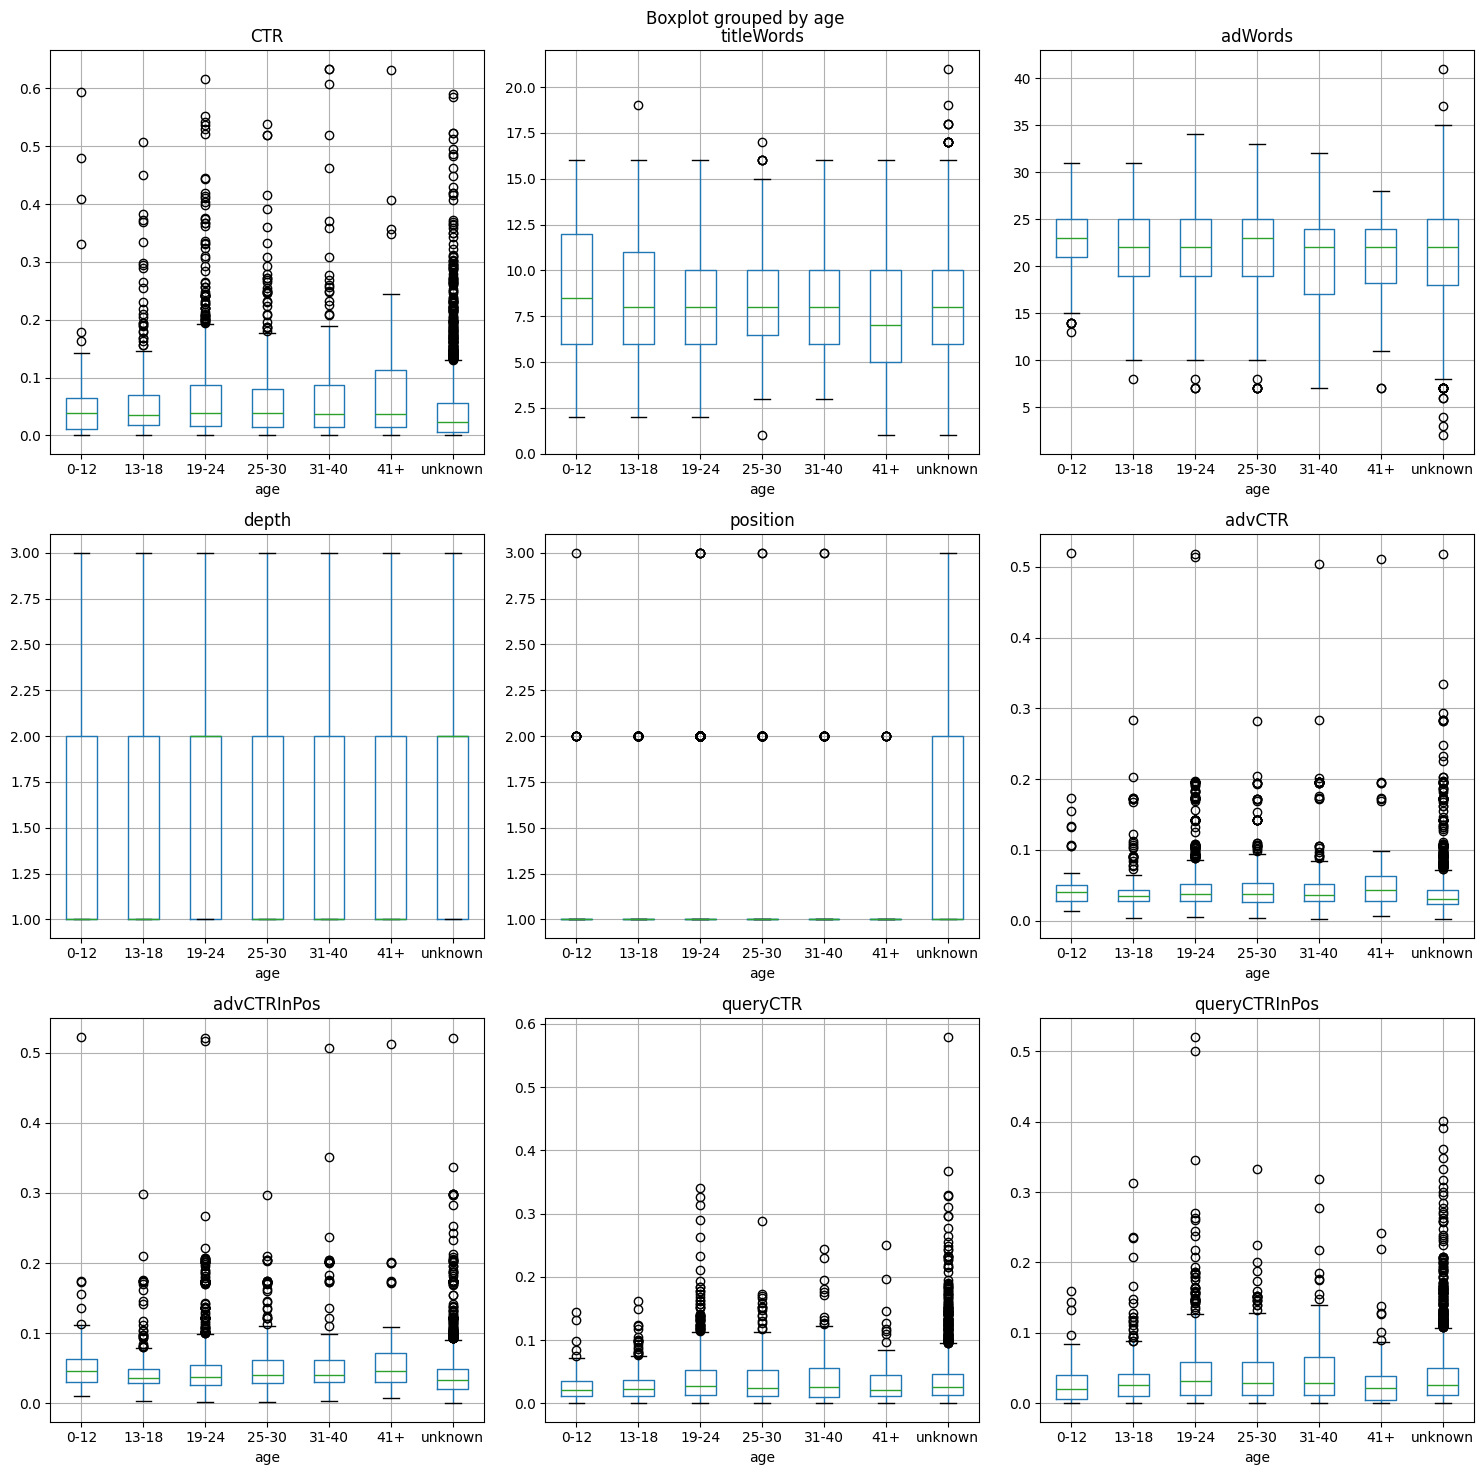

In [ ]:
# Analyzing the distribtion of the numerical values based on age group

# Create a figure and subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Iterate over numerical columns and plot boxplots for each gender
for i, col in enumerate(train_df[numerical_cols].columns):
    row = i // 3
    column = i % 3
    train_df.boxplot(column=col, by='age', ax=axes[row, column])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

We can see from the histograms and the boxplots above that most ads have CTR between 0-10%. In addtion, Title words and ad words seem to be somewhat nomrally distributed. Ads that target the age group 41+ seem to have slightly higher CTR and increased variability.

## 3. Bivariate Analysis (Relationships Between Two Variables)

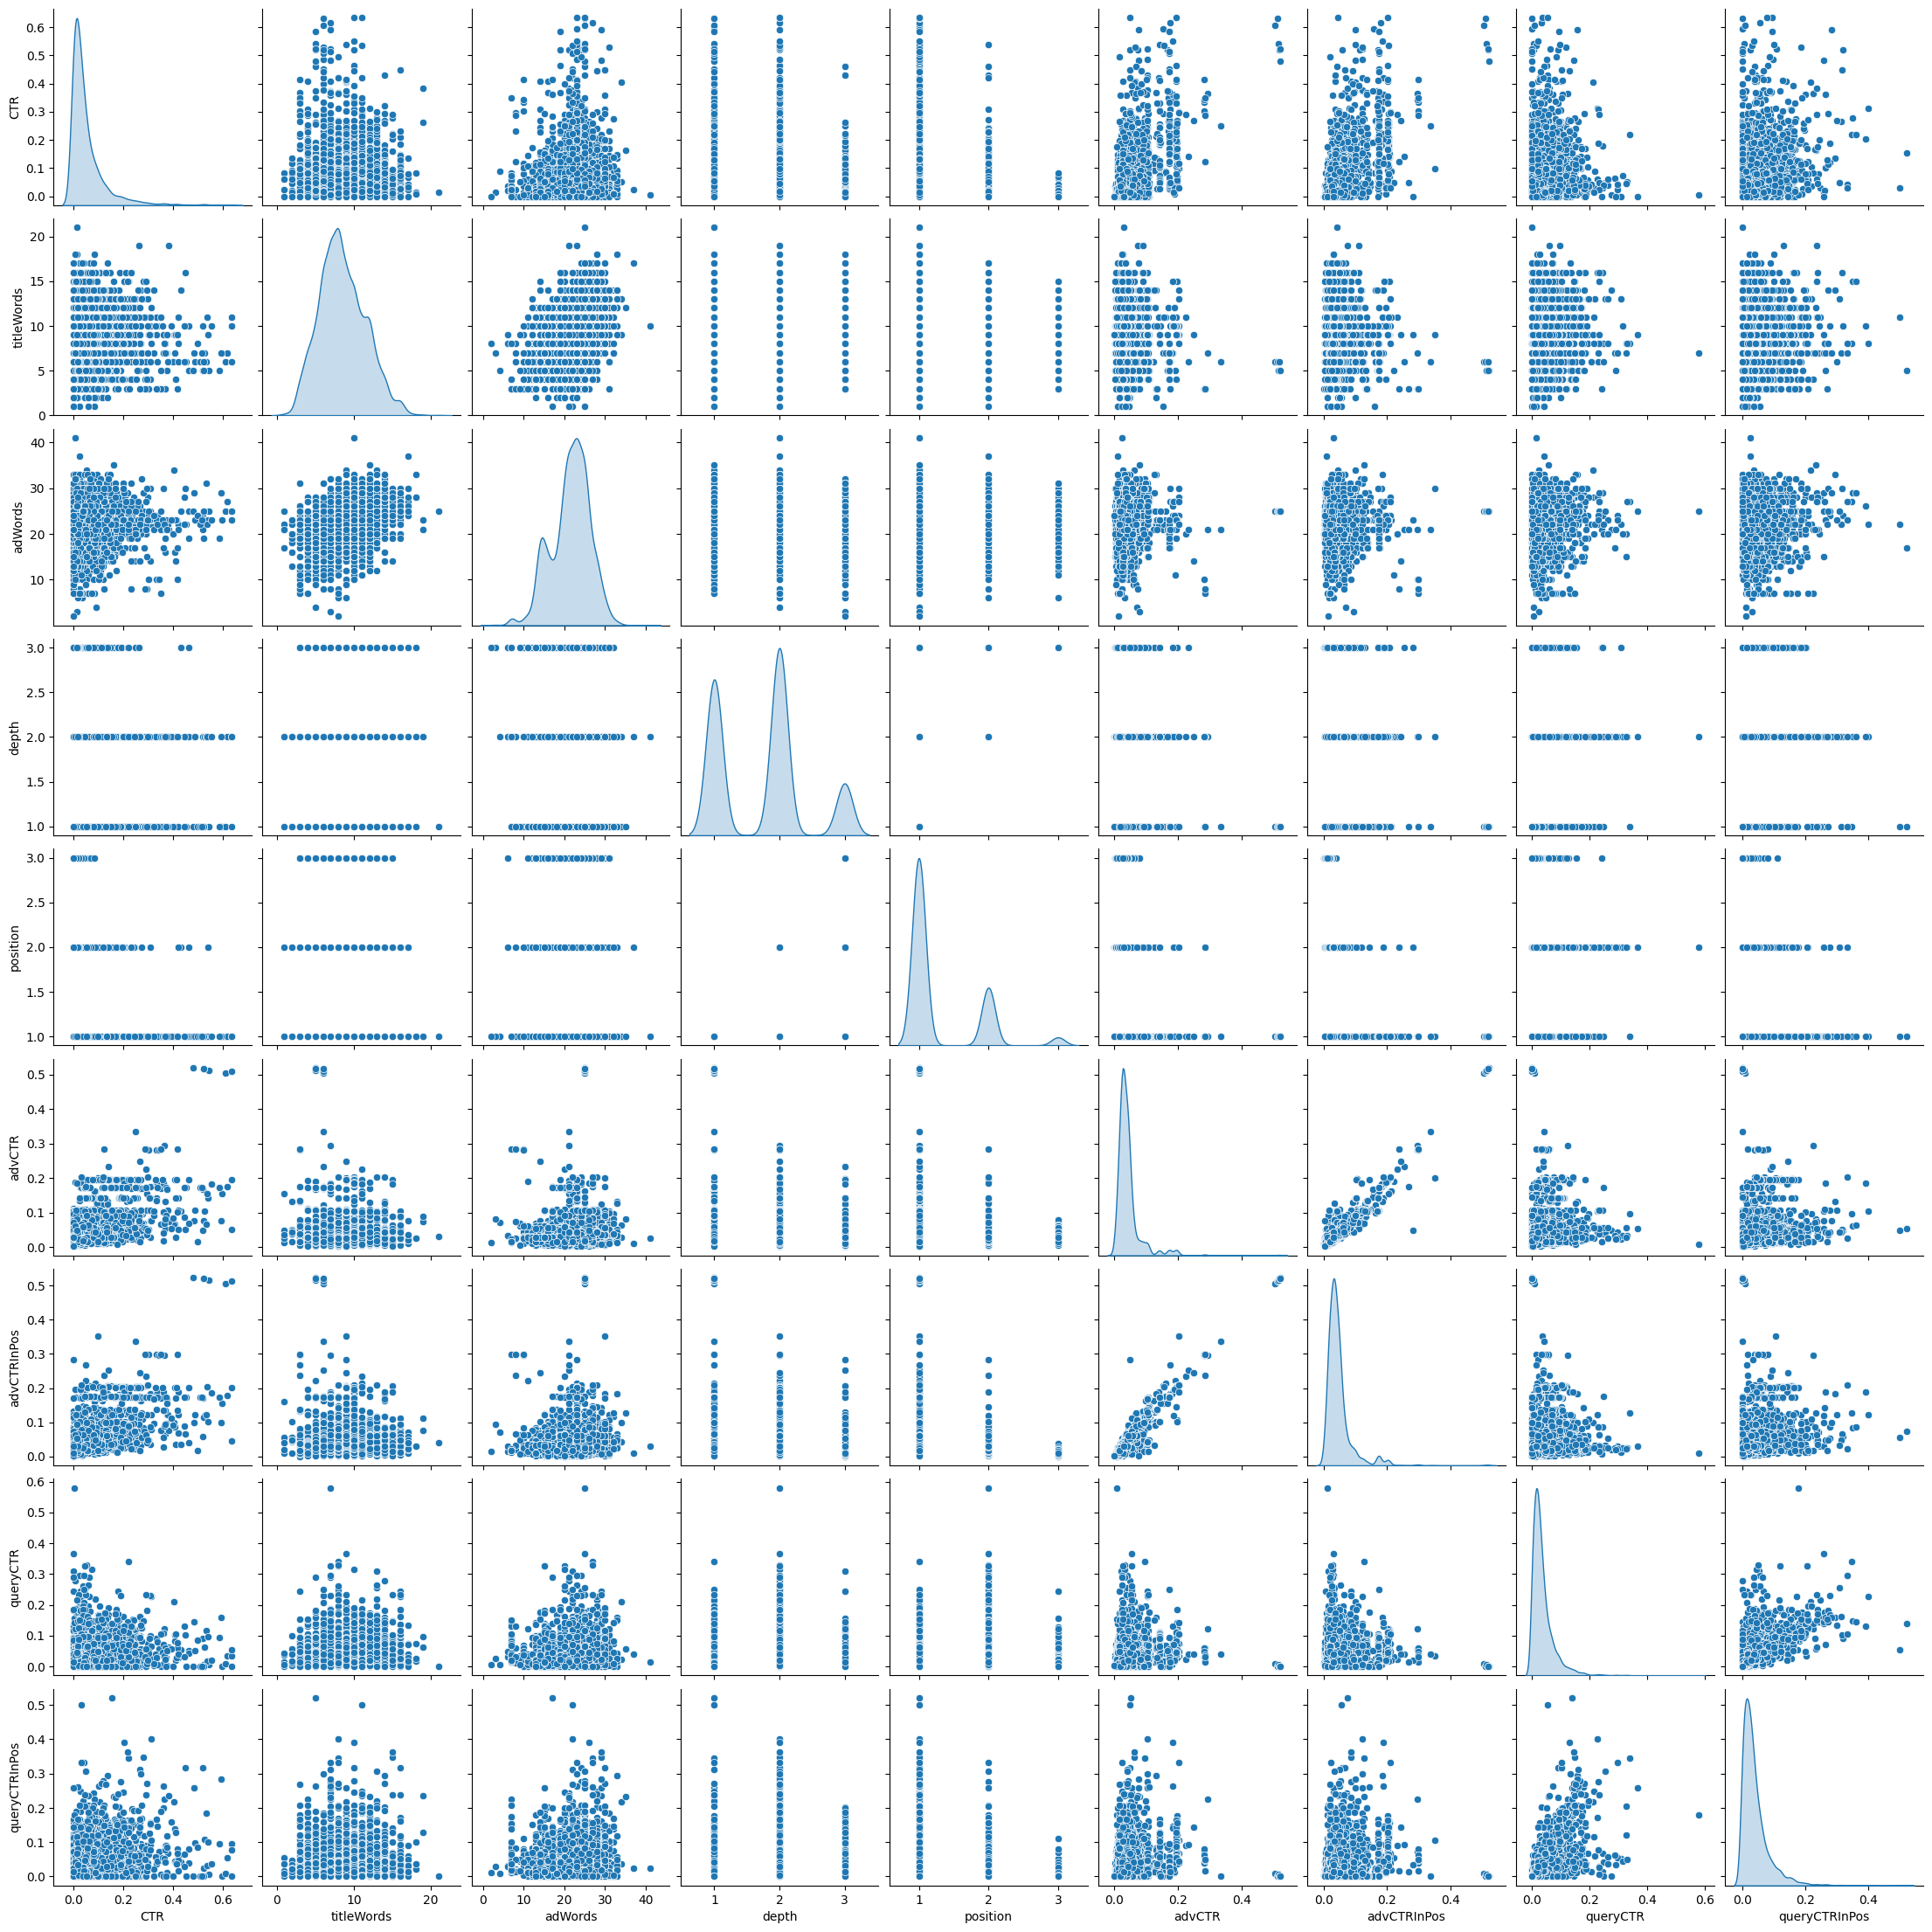

In [ ]:
# Analyzing relationsship between the variables
sns.pairplot(train_df, diag_kind='kde')
plt.show()

Looking at the relationships between the variables, focusing on CTR's relationship with the other variables, we see that there is an inverse relationship between CTR and position, meaning CTR decreases the lower it is positioned in the results. It also seems that CTR starts to drop once title words exceed 10, and that CTR peaks when ad words are around the 25-word mark.

##4. Modeling

In [ ]:
#Preparing y_train and y_test
y_train = train_df.pop('CTR')
y_test = test_df.pop('CTR')

In [ ]:
# We will be evaluating multiple predictive models for this dataset. To organize the results, we will create a master dataframe to store the performance data for each model:
model_performance_df = pd.DataFrame(columns=['model name', 'model description','osr2', 'mae', 'rmse'])

### Helper Functions

We will use some functions to evaluate results:


*   MAE (mean absolute error)
*   RMSE (root mean squared error)
*   OSR2 (out of sample R2)

We will apply these to the test set always so that our metrics are out-of-sample

In [ ]:
def OSR2(y_true, y_pred, training_mean):
  '''
  Returns out-of-sample R-squared
  '''
  baseline_error = np.sum(np.square((training_mean - y_true)))
  model_error = np.sum(np.square((y_pred - y_true)))
  return 1.0 - model_error/baseline_error


In [ ]:
def calc_metrics(y_true, y_pred, training_mean = y_train.mean()):
  '''
  Returns the out-of-sample R-squared, MAE, and RMSE
  '''
  osr2 = OSR2(y_test, y_pred, y_train.mean())
  mae = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))

  return osr2, mae, rmse

In [ ]:
def print_metrics(model, osr2, mae, rmse):
  '''
  Prints evaluations metrics for the out-of-sample R-squared, MAE, and RMSE
  '''
  print(f'Out-of-Sample R2 for {model.__class__.__name__} is: {osr2:.3f}')
  print(f'Mean Absolute Error for {model.__class__.__name__} is: {mae:.3f}')
  print(f'Root Mean Squared Error for {model.__class__.__name__} is: {rmse:.3f}')

In [ ]:
def append_dataframe(model, model_description, osr2, mae, rmse):
      '''
      Creates a new row for the model performance dataframe and appends it to the global dataframe
      '''
      global model_performance_df
      # Create a new row for the DataFrame
      new_row = {
        'model name': model.__class__.__name__,
        'model description': model_description,
        'osr2': osr2,
        'mae': mae,
        'rmse': rmse}

      #Append the new row to the global DataFrame
      model_performance_df = pd.concat([model_performance_df, pd.DataFrame([new_row])], ignore_index=True)

### Linear Regression

In [ ]:
# Preparing independant variables

#Copy dataframes
X_train = train_df.copy()
X_test = test_df.copy()

# Get dummies, for the linear regression model will drop the first first dummy of each categorical variable to avoid multicollinearity
X_train = pd.get_dummies(X_train, columns=['age','gender'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['age','gender'], drop_first=True)

In [ ]:
X_train.head()

,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,age_13-18,age_19-24,age_25-30,age_31-40,age_41+,age_unknown,gender_male,gender_unknown
0,10,17,3,2,0.0136,0.0146,0.0000,0.0000,False,False,False,False,True,False,True,False
1,13,30,2,1,0.0373,0.0465,0.0382,0.0581,True,False,False,False,False,False,True,False
2,12,14,1,1,0.0254,0.0310,0.0255,0.0323,True,False,False,False,False,False,True,False
3,5,19,3,2,0.0178,0.0076,0.0035,0.0017,False,False,True,False,False,False,False,False
4,11,17,2,2,0.0096,0.0069,0.0294,0.0171,False,True,False,False,False,False,False,False


In [ ]:
# Initiate and run the liner regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

#Make Prediction
y_pred = model_lr.predict(X_test)

#Calcualte Metrics
osr2, mae, rmse = calc_metrics(y_test, y_pred)
print_metrics(model_lr, osr2, mae, rmse)

Out-of-Sample R2 for LinearRegression is: 0.375
Mean Absolute Error for LinearRegression is: 0.036
Root Mean Squared Error for LinearRegression is: 0.060


In [ ]:
# Add the results of the linear regression model to the summary dataframe
append_dataframe(model_lr, 'Simple Linear Regression model', osr2, mae, rmse)
model_performance_df

/tmp/ipython-input-27-2777159540.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_performance_df = pd.concat([model_performance_df, pd.DataFrame([new_row])], ignore_index=True)


,model name,model description,osr2,mae,rmse
0,LinearRegression,Simple Linear Regression model,0.375306,0.035634,0.060185


In [ ]:
#Examine the coefficients of the model to understand which variables have the biggest impact on the prediction

pd.DataFrame({"Variable": X_train.columns, "Coefficient": model_lr.coef_}).sort_values(by='Coefficient', ascending=False)

,Variable,Coefficient
5,advCTRInPos,0.557652
7,queryCTRInPos,0.459923
4,advCTR,0.448779
13,age_unknown,0.028549
6,queryCTR,0.008432
12,age_41+,0.002304
2,depth,0.001969
1,adWords,0.000384
0,titleWords,-0.000522
8,age_13-18,-0.000537


We can see from table above that the variables with the highest impact on the prediction are:


*   the historic average CTR for the advertiser in the same position
*   The historic average CTR for the ad in the same position for this query
*   The average CTR for the adverstiser

This makes sense as generally you would expect past performance in similiar situations to be a good indicator of future outcomes.

<br>
<br>
<br>
<br>

Next we will look at CART models to see if we can get an improvement in performance

### CART for Regression

In [ ]:
# Preparing independant variables

#Copy dataframes
X_train = train_df.copy()
X_test = test_df.copy()

# Get dummies, for the tree models will NOT drop the first first dummy of each categorical variable as tree algorithms use all categories to determnine splits
X_train = pd.get_dummies(train, columns=['age','gender'])
X_test = pd.get_dummies(test, columns=['age','gender'])

Let's train a basic full tree first and observe its performance

In [ ]:
#Create a simple decsion tree classifier model
model_dtr = DecisionTreeRegressor(random_state=42).fit(X_train,y_train)
y_pred = model_dtr.predict(X_test)


#Calcualte Metrics
osr2, mae, rmse = calc_metrics(y_test, y_pred)
print_metrics(model_lr, osr2, mae, rmse)

Out-of-Sample R2 for LinearRegression is: 0.090
Mean Absolute Error for LinearRegression is: 0.041
Root Mean Squared Error for LinearRegression is: 0.073


In [ ]:
# Add the results of the basic decision tree regressor model to the summary dataframe
append_dataframe(model_dtr, 'basic decision tree regressor model', osr2, mae, rmse)
model_performance_df

,model name,model description,osr2,mae,rmse
0,LinearRegression,Simple Linear Regression model,0.375306,0.035634,0.060185
1,DecisionTreeRegressor,basic decision tree regressor model,0.089951,0.041369,0.072642


The performance of the basic tree is significantly worse than the linear regression. Let's prune the tree and see if that improves its performance.

In [ ]:
# With the default settings of the hyperparamters, CART model can easily overfit the data. a quick way to check for overfitting is to see how big the tree is
print('# of levels in the decision tree is: %.0f\n# of nodes in the dicsion tree is: %.0f'% (model_dtr.tree_.max_depth, model_dtr.tree_.node_count))

# of levels in the decision tree is: 33
# of nodes in the dicsion tree is: 7613


This is a huge tree: 33 levels deep with over 7,000 nodes. This is likely causing overfitting. We will prune this tree using cost-complexity pruning and see if we can mitigage that overfitting.

In [ ]:
# getting the ccp_alpha for the tree

path = model_dtr.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

In [ ]:
# Checking the number of trees since every ccp alphas correpsonsde to a different tree
len(alphas)

3257

In [ ]:
# 3257 is a large number of trees. To prevent excessive processing time, we will generate about 3% 0f the trees (approx. 100 trees), evenly sampled from the population

small_alphas = alphas[::30] #Picks every 30th alpha
small_alphas = small_alphas[::-1] # reverses the order of the list to start with the heigest alpha (the higher the alpha, the smaller the tree)

In [ ]:
len(small_alphas)

109

In [ ]:
small_alphas[:10]

array([2.88229245e-05, 1.02311730e-05, 6.34667701e-06, 4.52431752e-06,
       3.31188487e-06, 2.63886832e-06, 2.11334560e-06, 1.72080189e-06,
       1.48898616e-06, 1.24458104e-06])

In [ ]:
#Generate the trees and calcualte performance for in smaple and out of sample predictions

r2_all = []
osr2_all = []
node_counts = []

for alpha in small_alphas:
  #initiate new tree model using the ccp alphas to generate pruned trees
  tree = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
  tree.fit(X_train,y_train)

  #generate predections and calculate the in-sample r2
  y_pred = tree.predict(X_train)
  r2_all.append(OSR2(y_train, y_pred, y_train.mean()))

  #generate predections on calculate out-of-sample r2
  y_pred = tree.predict(X_test)
  osr2_all.append(OSR2(y_test, y_pred, y_train.mean()))

  #get the node count for the tree model
  node_counts.append(tree.tree_.node_count)

Text(0.5, 1.0, 'Prediction quality vs tree size')

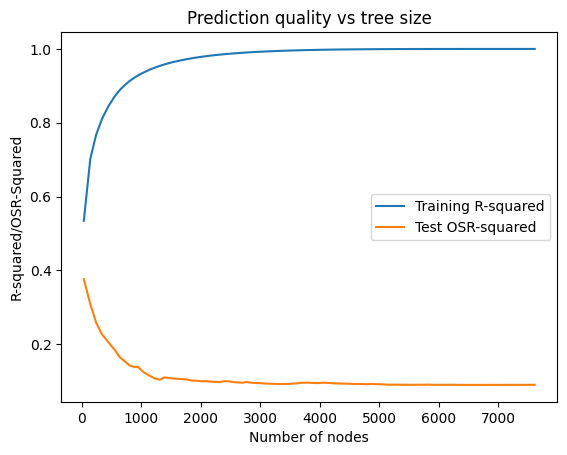

In [ ]:
#Plot the in-sample and out-of-sample r2 to observe potential overfitting

plt.plot(node_counts, r2_all, label='Training R-squared')
plt.plot(node_counts, osr2_all, label='Test OSR-squared')
plt.legend()
plt.xlabel('Number of nodes')
plt.ylabel('R-squared/OSR-Squared')
plt.title('Prediction quality vs tree size')

We can clearly see the overfitting. When the tree size (i.e., number of nodes) increases, the in-sample R2 gets better but the out-ofsample OSR2 decreases as overfitting kicks in. Therefore, we will go with a smaller tree that has a smaller nuber of nodes.

In [ ]:
#find the optimal number of nodes and corresponding performance metrics
optimal_idx = np.argmax(osr2_all)
optimal_osr2 = osr2_all[optimal_idx]

print('Optimal number of nodes is: %.0f' % node_counts[optimal_idx])
print('Optimal OSR2 is: %.3f' % optimal_osr2)

Optimal number of nodes is: 39
Optimal OSR2 is: 0.376


In [ ]:
#Get the alpha that corresponds to the best OSR2
opt_alpha = small_alphas[optimal_idx]
opt_alpha

np.float64(2.8822924537349378e-05)

In [ ]:
#Generate a tree using the optimal alpha

tree = DecisionTreeRegressor(ccp_alpha=opt_alpha, random_state=42).fit(X_train,y_train)
y_pred = tree.predict(X_test)

#Calculate performance metrics
osr2, mae, rmse = calc_metrics(y_test, y_pred)
print_metrics(tree, osr2, mae, rmse)

Out-of-Sample R2 for LinearRegression is: 0.376
Mean Absolute Error for LinearRegression is: 0.035
Root Mean Squared Error for LinearRegression is: 0.060


The pruned tree outperforms the initial tree significantly. Let's see how big is the pruned tree.

In [ ]:
tree.tree_.node_count, tree.tree_.max_depth

(39, 7)

In [ ]:
#Helper Funtion to visualize the tree
def viz_tree(tree, X, font=12, figsize=(16,10)):
  '''
  draws a CART tree
  '''
  plt.figure(figsize=figsize)  # set plot size (denoted in inches)
  _ = plot_tree(tree,
                feature_names=X.columns,
                filled=True,
                fontsize=font)

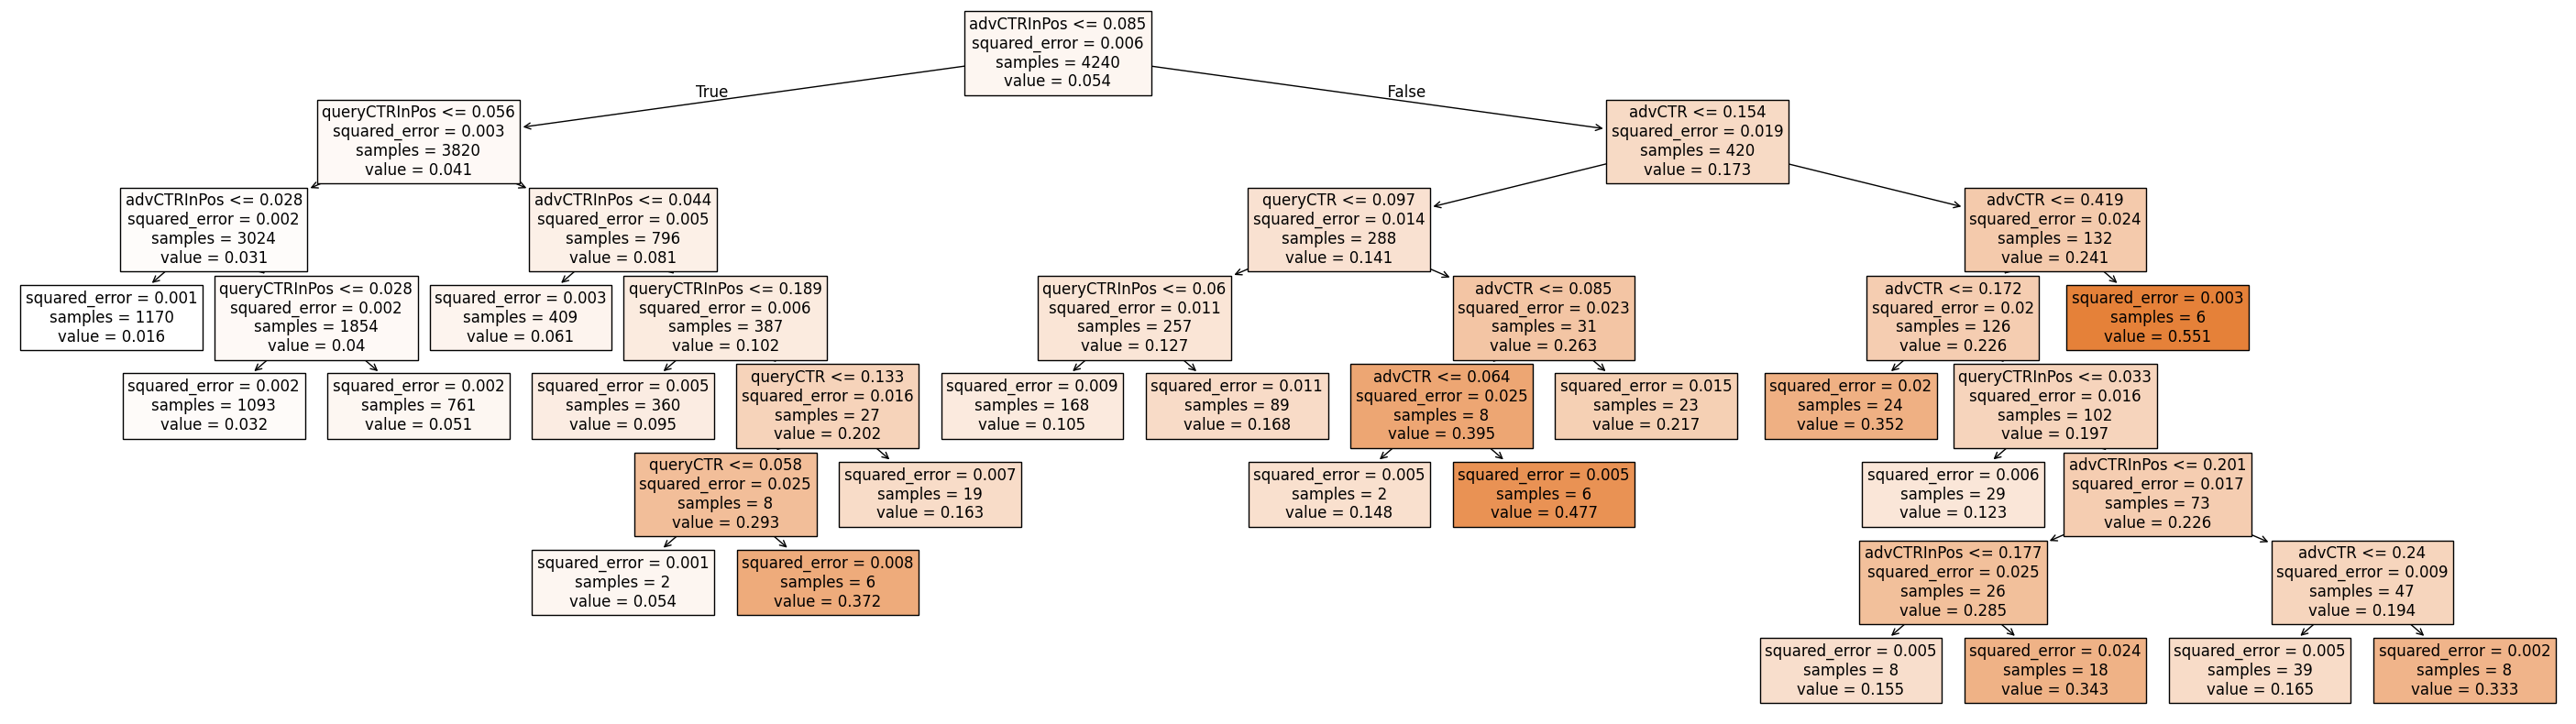

In [ ]:
#Visualze the tree
viz_tree(tree, X_train, figsize=(36,10))

We can the most predictive variables in the tree are similiar to those identified in the linear regression model. The only differrnce is that the tree identified queryCTR (average CTR for the query) as an additional variable that is significant in predicting the CTR value.

In [ ]:
# Add the results of the pruned tree to the summary dataframe
append_dataframe(model_dtr, 'Pruned decision tree regressor model', osr2, mae, rmse)
model_performance_df

,model name,model description,osr2,mae,rmse
0,LinearRegression,Simple Linear Regression model,0.375306,0.035634,0.060185
1,DecisionTreeRegressor,basic decision tree regressor model,0.089951,0.041369,0.072642
2,DecisionTreeRegressor,Pruned decision tree regressor model,0.376339,0.034889,0.060135


<br>
<br>
<br>
Although the pruned tree is a huge imporvement from the initial tree, we can see it is still only slightly better than the simple regresison tree.  Let's if we can use ensamble models to gain on performance.
<br>
<br>
<br>

### Random Forests

In [ ]:
# Let's train a Random Forest model with all default settings.

model_rfr = RandomForestRegressor(random_state=42, n_jobs= -1).fit(X_train,y_train)
y_pred = model_rfr.predict(X_test)

#Calculate performance metrics
osr2, mae, rmse = calc_metrics(y_test, y_pred)
print_metrics(model_rfr, osr2, mae, rmse)

Out-of-Sample R2 for RandomForestRegressor is: 0.466
Mean Absolute Error for RandomForestRegressor is: 0.032
Root Mean Squared Error for RandomForestRegressor is: 0.056


In [ ]:
# Add the results of the pruned tree to the summary dataframe
append_dataframe(model_rfr, 'basic random forest regressor model', osr2, mae, rmse)
model_performance_df

,model name,model description,osr2,mae,rmse
0,LinearRegression,Simple Linear Regression model,0.375306,0.035634,0.060185
1,DecisionTreeRegressor,basic decision tree regressor model,0.089951,0.041369,0.072642
2,DecisionTreeRegressor,Pruned decision tree regressor model,0.376339,0.034889,0.060135
3,RandomForestRegressor,basic random forest regressor model,0.465860,0.032370,0.055652


The random forest model even at its default settings is a significant improvement on the pruned tree model. Let's see if we can tune its hyper parameters to imporove the performance further.


In [ ]:
# Define the parameter distributions for RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1.0, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}


# Set up RandomizedSearchCV
rcv = RandomizedSearchCV(estimator=model_rfr, param_distributions=param_dist,
                                   n_iter=20, cv=5, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV to the training data
rcv.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", rcv.best_params_)

Best parameters found:  {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}


In [ ]:
# Get the best model
best_rfr = rcv.best_estimator_

In [ ]:
#Generte predictions using the best model
y_pred = best_rfr.predict(X_test)

#Calculate performance metrics
osr2, mae, rmse = calc_metrics(y_test, y_pred)
print_metrics(best_rfr, osr2, mae, rmse)

Out-of-Sample R2 for RandomForestRegressor is: 0.496
Mean Absolute Error for RandomForestRegressor is: 0.031
Root Mean Squared Error for RandomForestRegressor is: 0.054


In [ ]:
# Add the results of the pruned tree to the summary dataframe
append_dataframe(best_rfr, 'tuned random forest regressor model', osr2, mae, rmse)
model_performance_df

,model name,model description,osr2,mae,rmse
0,LinearRegression,Simple Linear Regression model,0.375306,0.035634,0.060185
1,DecisionTreeRegressor,basic decision tree regressor model,0.089951,0.041369,0.072642
2,DecisionTreeRegressor,Pruned decision tree regressor model,0.376339,0.034889,0.060135
3,RandomForestRegressor,basic random forest regressor model,0.465860,0.032370,0.055652
4,RandomForestRegressor,tuned random forest regressor model,0.496409,0.030990,0.054037


The tuned random forest model shows further imporvement on the previous models with the best performance numbers yet.
<br>
<br>
Let's try a boosted tree model next and see if we can get even better performance.

### XGBoost

In [ ]:
#Create a basic XGB Regresor model and generate predictions
model_xgbr = XGBRegressor(random_state=42)
model_xgbr.fit(X_train, y_train)
y_pred = model_xgbr.predict(X_test)

#Calculate performance metrics
osr2, mae, rmse = calc_metrics(y_test, y_pred)
print_metrics(model_xgbr, osr2, mae, rmse)

Out-of-Sample R2 for XGBRegressor is: 0.470
Mean Absolute Error for XGBRegressor is: 0.032
Root Mean Squared Error for XGBRegressor is: 0.055


In [ ]:
# Add the results of the pruned tree to the summary dataframe
append_dataframe(model_xgbr, 'basic xgboost regressor model', osr2, mae, rmse)
model_performance_df

,model name,model description,osr2,mae,rmse
0,LinearRegression,Simple Linear Regression model,0.375306,0.035634,0.060185
1,DecisionTreeRegressor,basic decision tree regressor model,0.089951,0.041369,0.072642
2,DecisionTreeRegressor,Pruned decision tree regressor model,0.376339,0.034889,0.060135
3,RandomForestRegressor,basic random forest regressor model,0.465860,0.032370,0.055652
4,RandomForestRegressor,tuned random forest regressor model,0.496409,0.030990,0.054037
5,XGBRegressor,basic xgboost regressor model,0.469859,0.032231,0.055443


The basic XGBoost model shows good performance although not as agood as the tuned random forest model. Let's tune the hyper parameters of the XGBoost model and see if performance improves.



In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_grid = {'n_estimators': range(10, 1010, 10),
              'max_depth': range(1, 21),
              'learning_rate': np.linspace(0.001, 1.0, 50),
              'min_child_weight': range(1, 201),
              'subsample': np.arange(0.7, 1.1, 0.1),
              'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
              }

#Create evaluation set
eval_set = [(X_test, y_test)]

#Create an XGBoost Regressor model:
model_xgbr_tuned = XGBRegressor(random_state=42, early_stopping_rounds=20, n_jobs = -1)

#setup a RandomizedSearchCV
rcv = RandomizedSearchCV(model_xgbr_tuned,
                        param_distributions = param_grid,
                        cv=5,
                        n_iter=10,
                        scoring='neg_mean_absolute_error',
                        random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV to the training data
rcv.fit(X_train, y_train, eval_set = eval_set, verbose = False)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=20,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=No...
       0.61263265, 0.63302041, 0.65340816, 0.67379592, 0.69418367,
       0.71457143, 0.73495918, 0.75534694, 0.77573469, 0.79612245,
       0.8165102 , 0.83689796, 0.85728571, 0.87767347, 0.89806122,
       0.91844898, 0.93883673, 0.95922449, 0.97961224, 1.        ]),
                                        'max_depth': range(1, 21),
                                        'min_child_weight': range(1, 201),
                                        'n_estimators': range(10, 1010, 10),
                                        'subsample': array([0.7, 0.8, 0.9, 1. , 1.1])},
                   random_state=42, scoring='neg_mean_absolute_error')

In [ ]:
# Print the best parameters found
print("Best parameters found: ", rcv.best_params_)

Best parameters found:  {'subsample': np.float64(0.8999999999999999), 'n_estimators': 760, 'min_child_weight': 49, 'max_depth': 3, 'learning_rate': np.float64(0.041775510204081635), 'colsample_bytree': 1.0}


In [ ]:
#Examine all combinations generarted by the random search moodel:
pd.DataFrame(rcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.581032,0.066034,0.015470,0.004058,0.7,200,2,20,1.000000,0.8,"{'subsample': 0.7, 'n_estimators': 200, 'min_c...",-0.041689,-0.040877,-0.040371,-0.037099,-0.036282,-0.039264,0.002158,10
1,0.412632,0.082661,0.022001,0.004416,0.9,990,181,12,0.245653,1.0,"{'subsample': 0.8999999999999999, 'n_estimator...",-0.035943,-0.033314,-0.034080,-0.033489,-0.033146,-0.033994,0.001024,5
2,0.076215,0.004309,0.012708,0.000427,0.9,10,152,10,0.510694,0.9,"{'subsample': 0.8999999999999999, 'n_estimator...",-0.036339,-0.033455,-0.034491,-0.034107,-0.033403,-0.034359,0.001071,6
3,0.264113,0.043043,0.016073,0.001251,1.0,730,44,16,0.266041,0.8,"{'subsample': 0.9999999999999999, 'n_estimator...",-0.037055,-0.033249,-0.032450,-0.032305,-0.031435,-0.033299,0.001965,4
4,0.259393,0.031704,0.019254,0.007459,1.0,80,49,13,0.327204,0.8,"{'subsample': 0.9999999999999999, 'n_estimator...",-0.036892,-0.033058,-0.032542,-0.032053,-0.031418,-0.033193,0.001928,3
5,1.214614,0.026650,0.028080,0.010414,0.9,760,49,3,0.041776,1.0,"{'subsample': 0.8999999999999999, 'n_estimator...",-0.035372,-0.032485,-0.032743,-0.031709,-0.031218,-0.032705,0.001440,1
6,0.268406,0.063968,0.017016,0.005053,0.8,940,41,12,0.327204,0.8,"{'subsample': 0.7999999999999999, 'n_estimator...",-0.036228,-0.032273,-0.032794,-0.032424,-0.031734,-0.033090,0.001605,2
7,0.466987,0.212344,0.033494,0.013970,0.7,430,135,15,0.490306,0.9,"{'subsample': 0.7, 'n_estimators': 430, 'min_c...",-0.037360,-0.034992,-0.034767,-0.034274,-0.033754,-0.035029,0.001241,8
8,0.444349,0.127670,0.032571,0.013500,1.0,440,93,19,0.612633,1.0,"{'subsample': 0.9999999999999999, 'n_estimator...",-0.039233,-0.033882,-0.035187,-0.033622,-0.033981,-0.035181,0.002097,9
9,0.530767,0.140573,0.026071,0.010691,1.0,500,52,16,0.592245,1.0,"{'subsample': 0.9999999999999999, 'n_estimator...",-0.037886,-0.034258,-0.033494,-0.033977,-0.032480,-0.034419,0.001836,7


In [ ]:
#use the best XGB Regresor model from the RandomizedGridSearch to generate predictions
best_xgbr = rcv.best_estimator_
y_pred = best_xgbr.predict(X_test)

#Calculate performance metrics
osr2, mae, rmse = calc_metrics(y_test, y_pred)
print_metrics(best_xgbr, osr2, mae, rmse)

Out-of-Sample R2 for XGBRegressor is: 0.483
Mean Absolute Error for XGBRegressor is: 0.032
Root Mean Squared Error for XGBRegressor is: 0.055


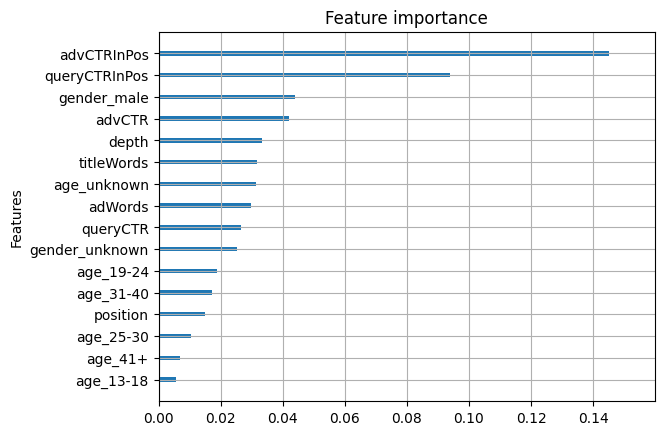

In [ ]:
# Examine the feature importance to determine the varaibles with the most impact on predicting the CTR
plot_importance(rcv.best_estimator_, importance_type='gain', show_values=False, xlabel='');

Interestingly, the XGBoost model identified the gender_male as an important feature in determining CTR, in addition to other variables identified by the previous models.

In [ ]:
# Add the results of the pruned tree to the summary dataframe
append_dataframe(best_xgbr, 'tuned xgboost regressor model', osr2, mae, rmse)
model_performance_df

,model name,model description,osr2,mae,rmse
0,LinearRegression,Simple Linear Regression model,0.375306,0.035634,0.060185
1,DecisionTreeRegressor,basic decision tree regressor model,0.089951,0.041369,0.072642
2,DecisionTreeRegressor,Pruned decision tree regressor model,0.376339,0.034889,0.060135
3,RandomForestRegressor,basic random forest regressor model,0.465860,0.032370,0.055652
4,RandomForestRegressor,tuned random forest regressor model,0.496409,0.030990,0.054037
5,XGBRegressor,basic xgboost regressor model,0.469859,0.032231,0.055443
6,XGBRegressor,tuned xgboost regressor model,0.483325,0.032046,0.054735


In [ ]:
#Examine the performance of all the models through the summary dataframe
model_performance_df.sort_values(by='osr2', ascending=False)

,model name,model description,osr2,mae,rmse
4,RandomForestRegressor,tuned random forest regressor model,0.496409,0.030990,0.054037
6,XGBRegressor,tuned xgboost regressor model,0.483325,0.032046,0.054735
5,XGBRegressor,basic xgboost regressor model,0.469859,0.032231,0.055443
3,RandomForestRegressor,basic random forest regressor model,0.465860,0.032370,0.055652
2,DecisionTreeRegressor,Pruned decision tree regressor model,0.376339,0.034889,0.060135
0,LinearRegression,Simple Linear Regression model,0.375306,0.035634,0.060185
1,DecisionTreeRegressor,basic decision tree regressor model,0.089951,0.041369,0.072642


After analyzing the performance of the models generated in this notebook, it appears the tuned random forest regressor has the best performance of all the models examined, followed by the tuned XGB regressor. It is important to note  that the random search method is not exhaustive and, therefore, does not guarantee finding the best model since it does not iterate through all the possible combinations.
<br>
<br>
<br>
given more time and resources, RCV could be run on more iterations to see if there are other combinations of parameters that yield better performance.